In [ ]:
from spx_analysis import simulate_market 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime as dt, timedelta

In [ ]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

spx.index = pd.to_datetime(spx.index).year
spx['daily_chg'] = np.log(spx['Adj Close']) - np.log(spx['Adj Close'].shift(1))

## Simulating a market

In [321]:
years = 60

start_date = dt(2020, 1, 1)
end_date = dt(2080, 12, 31)
days = pd.date_range(start_date, end_date, freq='B')

# Random market
market = simulate_market(start_date, end_date, spx['daily_chg'][-20*252:]*100)
market.set_index(days, inplace=True)

# Annualizing returns
market = market.asfreq('Y', method='ffill', normalize=True)
market.index = market.index.year

15915


## Combining with investment profile

In [322]:
inv_plan = pd.read_csv('investment_plan.csv', sep=';', index_col=0)
market['Price'] = market['Price']*100/market['Price'].iloc[0]

In [323]:
def calculate_return(inv, market):
    assert len(inv) == len(market), 'Investment plan should be same no of periods as market' 
    inv['Roll_contribution'] = inv['Contributions'].cumsum()
    inv['Price'] = market['Price']
    inv['Account_value'] = 0
    inv['Total_debt'] = 0
    inv['New_debt'] = 0
    inv['Dollar_return'] = 0
    
    inv['Return'] = inv['Price'].pct_change()
    
    
    # Calculating debt
    for i in range(len(inv)):
        interest_rate = inv.iloc[i, 2]
        gearing = inv.iloc[i, 0]
        cont = inv.iloc[i, 1]
        new_debt = max(gearing-1, 0)*cont
        inv.iloc[i, 7] = new_debt
        
        # Calculating interest and total debt
        if i > 0:
            previous_debt = inv.iloc[i-1, 6]
            accrued_interest = previous_debt*(1+interest_rate)
        else:
            accrued_interest = 0
        
        total_debt = new_debt + accrued_interest
        inv.iloc[i, 6] = total_debt
    
        # Calculating total return
        if i == 0:
            account_value = new_debt + cont
        else:
            previous_account_value = inv.iloc[i-1, 5]
            period_return = inv.iloc[i, 9]
            account_value = (previous_account_value + (new_debt + cont))*(1+period_return)
        

        inv.iloc[i, 5] = account_value
        # Dollar return net debt
        inv.iloc[i, 8] = account_value - total_debt


    return inv

In [324]:
port = calculate_return(inv_plan, market)

Text(0.5, 1.0, 'Portfolio contributions')

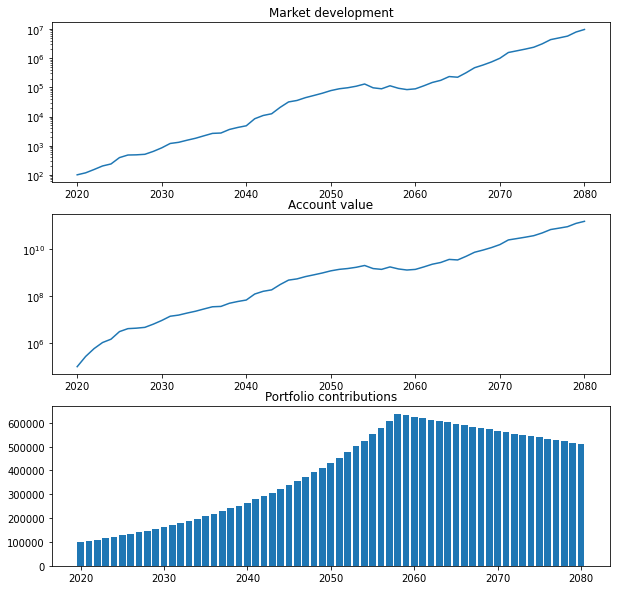

In [325]:
fig,ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(port['Price'])
ax[0].set_title('Market development')
ax[0].set_yscale('log')
ax[1].plot(port['Dollar_return'])
ax[1].set_title('Account value')
ax[1].set_yscale('log')
ax[2].bar(height=port['Contributions'], x=port.index)
ax[2].set_title('Portfolio contributions')